<a href="https://colab.research.google.com/github/tbeucler/2023_SD_REP/blob/main/Figures_Tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We designed this notebook so that it can be run in Google Colab. To prepare the data, **please upload `RV_Zip_Count.csv`and `Spatial_Join_SVI.dbf` in "Files"**.  

We will install the required Python libraries, pre-process the data, then calculate simple statistics, and finally reproduce the study's figures.

# Python Libraries Installation and Import

In [1]:
#@title Install the required libraries (we specify the version to facilitate reproducibility)
!pip install pandas==1.5.3
!pip install simpledbf==0.2.6
!pip install numpy==1.23.0
!pip install matplotlib==3.7.2

In [2]:
#@title Import the required libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np

import pandas as pd

import simpledbf
from simpledbf import Dbf5

In [3]:
#@title Change font type to match JAMA style

# Font properties
plt.rcParams['font.size'] = 12

In [4]:
#@title Load the TTF Times New Roman font files and set as default font
font_paths = {
    'regular': '/content/times.ttf',
    'bold': '/content/timesbd.ttf',
    'italic': '/content/timesi.ttf',
    'bold_italic': '/content/timesbi.ttf',
}

font_props = {
    'regular': fm.FontProperties(fname=font_paths['regular']),
    'bold': fm.FontProperties(fname=font_paths['bold']),
    'italic': fm.FontProperties(fname=font_paths['italic']),
    'bold_italic': fm.FontProperties(fname=font_paths['bold_italic']),
}

# Register the fonts with Matplotlib
font_manager = fm.FontManager()
for font_style, font_prop in font_props.items():
    font_manager.ttflist.append(font_prop)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Data Pre-Processing

## Calculate the drop in Week 10-15 respiratory visits between 2016-2019 and 2020 per San Diego zipcode

In [71]:
# Read the data from a CSV file
rv_zip_count = pd.read_csv('RV_Zip_Count.csv')

In [72]:
# Duplicate rv_zip_count, but only keep 'week_of_year' from 10 to 15
rv_zip_count_week_10_15 = rv_zip_count[rv_zip_count['week_of_year'].isin([10, 11, 12, 13, 14, 15])]

In [73]:
# Per zip code and per year, sum all the patients from 'week_of_year' from 10 to 15
rv_zip_sum_week_10_15 = rv_zip_count_week_10_15.groupby(['zip', 'year'])['Number of patients'].sum().reset_index()

In [74]:
# Now average all years together except 2020
# Average all years together except 2020
diff = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] != 2020]
diff = (diff.groupby('zip')['Number of patients'].sum()/4).reset_index()

In [75]:
# Replace the name of the column "Number of patients" with "2016-2019" in diff
diff.rename(columns={'Number of patients': '2016-2019'}, inplace=True)

In [76]:
# Extract the number of patients in 2020 from rv_zip_sum_week_10_15
rv_zip_2020 = rv_zip_sum_week_10_15[rv_zip_sum_week_10_15['year'] == 2020]

In [77]:
# Loop over zipcodes in diff to merge the 2016-2019 & 2020 visits in the same structure
# If the zipcode is in rv_zip_2020, assign rv_zip_2020['Number of patients'] to diff['2020']
for index, row in diff.iterrows():
  if row['zip'] in rv_zip_2020['zip'].values:
    diff.loc[index, '2020'] = rv_zip_2020.loc[rv_zip_2020['zip'] == row['zip']]['Number of patients'].values[0]
  else: diff.loc[index, '2020'] = 0.0

In [78]:
# Subtract the number of patients in diff from the number of patients in rv_zip_2020
# Divide weeks 10-15 by 6 to get weekly drop in pediatric respiratory visits
diff['six-week-diff'] = (diff['2020'] - diff['2016-2019'])
diff['drop_in_patients'] = -diff['six-week-diff']/6 # Per week
diff['relative_drop'] = -100*diff['six-week-diff']/diff['2016-2019'] # In % with respect to 2016-2019 average

In [79]:
# Only keep San Diego zipcodes
# Delete all rows corresponding to 'zip' greater than 92199 and smaller than 91901
diff = diff[(diff['zip'] <= 92199) & (diff['zip'] >= 91901)]

In [80]:
diff

,zip,2016-2019,2020,six-week-diff,drop_in_patients,relative_drop
149,91901,9.75,8.0,-1.75,0.291667,17.948718
150,91902,10.25,5.0,-5.25,0.875000,51.219512
151,91903,0.50,0.0,-0.50,0.083333,100.000000
152,91905,1.25,0.0,-1.25,0.208333,100.000000
153,91906,4.50,4.0,-0.50,0.083333,11.111111
...,...,...,...,...,...,...
273,92177,0.25,1.0,0.75,-0.125000,-300.000000
274,92178,0.25,1.0,0.75,-0.125000,-300.000000
275,92192,0.50,0.0,-0.50,0.083333,100.000000
276,92196,0.25,0.0,-0.25,0.041667,100.000000


## Pre-Process database containing spatially-joined zipcodes and CDC social vulnerability indices

In [81]:
# Path to the spatially-joined zipcode and SVIs
path_dbf = '/content/Spatial_Join_Zip_SVI.dbf'

In [82]:
dbf = Dbf5(path_dbf) # Load dbf file
svi = dbf.to_dataframe() # Convert to pd dataframe
svi['zip'] = svi['zip'].astype('int') # Convert zipcodes to integers
svi = svi.replace(-999, np.nan) # Replace -999 values with NaN following CDC conventions

In [83]:
# Group SVI statistics by zip code
svi_zip = {}
svi_zip['zipcode'] = svi.groupby('zip')['zip'].unique().astype('int')

svi_zip['all_mean'] = svi.groupby('zip')['RPL_THEMES'].mean()
svi_zip['socioeconomic_mean'] = svi.groupby('zip')['RPL_THEME1'].mean()
svi_zip['household_mean'] = svi.groupby('zip')['RPL_THEME2'].mean()
svi_zip['minority_mean'] = svi.groupby('zip')['RPL_THEME3'].mean()
svi_zip['housing_mean'] = svi.groupby('zip')['RPL_THEME4'].mean()

svi_zip['all_min'] = svi.groupby('zip')['RPL_THEMES'].min()
svi_zip['socioeconomic_min'] = svi.groupby('zip')['RPL_THEME1'].min()
svi_zip['household_min'] = svi.groupby('zip')['RPL_THEME2'].min()
svi_zip['minority_min'] = svi.groupby('zip')['RPL_THEME3'].min()
svi_zip['housing_min'] = svi.groupby('zip')['RPL_THEME4'].min()

svi_zip['all_max'] = svi.groupby('zip')['RPL_THEMES'].max()
svi_zip['socioeconomic_max'] = svi.groupby('zip')['RPL_THEME1'].max()
svi_zip['household_max'] = svi.groupby('zip')['RPL_THEME2'].max()
svi_zip['minority_max'] = svi.groupby('zip')['RPL_THEME3'].max()
svi_zip['housing_max'] = svi.groupby('zip')['RPL_THEME4'].max()

In [84]:
# Convert svi_zip to a pandas dataframe
svi_zip = pd.DataFrame(svi_zip)

## Link mean weekly drop in respiratory visits to CDC social vulnerability indices

In [85]:
# Merge diff with svi_zip based on 'zip'
svi_zip_diff = svi_zip.merge(diff, on='zip')

# Zipcode-Based Statistics

First, we have to design a population-weighting scheme to avoid giving too much weight to zipcodes that have very few patients over the 2016-2020 periods. To do this, we will weigh our correlations by 2016-2019 average patient population over the six weeks of interest (10-15).

In [88]:
#@title Weighted mean, covariance, and Pearson correlation functions
# From https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def w_m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def w_cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - w_m(x, w)) * (y - w_m(y, w))) / np.sum(w)

def w_corr(x, y, w):
    """Weighted Correlation"""
    return w_cov(x, y, w) / np.sqrt(w_cov(x, x, w) * w_cov(y, y, w))

In [89]:
#@title Weighted correlation of `key_interest` with all keys in the dictionary
def w_corr_dic(dic, key_interest, weighting_key=None):
  w_corr_dic = {} # Initialize the dictionary
  # Calculate weighted correlations; use uniform weightining if w_key argument is None
  for key in dic.keys():
    if weighting_key:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[weighting_key])
    else:
      w_corr_dic[key] = w_corr(dic[key_interest], dic[key], dic[key_interest]**0)

  return w_corr_dic

In [90]:
#@title Plotting routines for correlations
def plot_correlations(correlation_dictionary):
  fig,ax = plt.subplots(figsize=(12.5,5))
  # Sort correlations
  cor_sorted = sorted(correlation_dictionary.items(), key=lambda x: x[1])
  # extract labels and values
  labels = [value[0] for value in cor_sorted]
  values = [value[1] for value in cor_sorted]

  # create a horizontal bar plot
  plt.barh(labels, values)

  # add labels and title
  plt.xlabel('Pearson correlation')
  plt.title('Correlations')

  return fig,ax

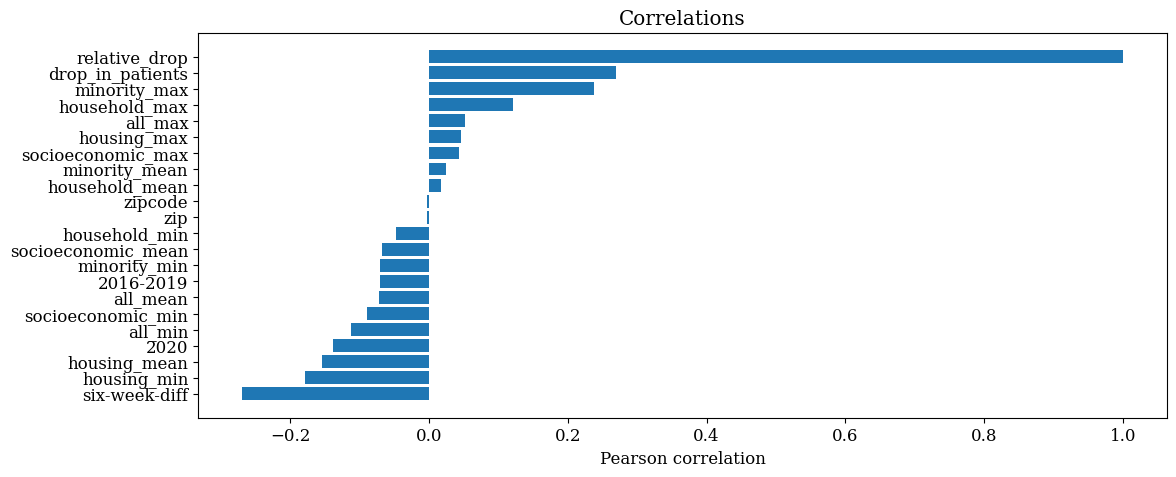

In [95]:
plot_correlations(w_corr_dic(dic = svi_zip_diff,
                             key_interest = 'relative_drop',
                             weighting_key= None));

In [ ]:
# Find the column that anti-correlates best with the 'diff' column
# Use Pearson correlation coefficient to find the column that correlates best with 'diff'
corr_matrix = svi_zip_diff.corr(method='pearson', numeric_only=True)
# Find the column that correlates best with the 'drop_in_patients' column
best_corr = corr_matrix['drop_in_patients'].sort_values(ascending=False)

In [ ]:
best_corr

The best correlation with the absolute `drop_in_patients` is the `2016-2019` average number of patients. This is unsurprising: There will be a larger drop if there are more patients to begin with. Let's normalize the drop by the number of patients and recalculate our correlations.

In [ ]:
svi_zip_diff['Drop_in_percent'] = 100*svi_zip_diff['six-week-diff']/svi_zip_diff['2016-2019']

In [ ]:
svi_zip_diff['Relative_drop'] = svi_zip_diff['drop_in_patients']/svi_zip_diff['2016-2019']
corr_matrix = svi_zip_diff.corr(method='pearson', numeric_only=True)
best_corr = corr_matrix['Relative_drop'].sort_values(ascending=False)

In [ ]:
# Save svi_zip_diff in csv format
svi_zip_diff.to_csv('svi_zip_diff.csv', index=False)

In [ ]:
best_corr

The relative drop suggests there is a correlation

In [ ]:
# Find the column that correlates best with the 'drop_in_patients' column
best_corr = corr_matrix['2016-2019'].sort_values(ascending=False)

In [ ]:
best_corr

In [ ]:
# Extract county-mean SVIs
best_corr_mean = {k:v for k,v in best_corr.items() if 'mean' in k}

In [ ]:
best_corr_mean

In [ ]:
# Turn it into a horizontal bar plot
fig,ax = plt.subplots(figsize=(12.5,7.5))
# extract labels and values
labels = list(best_corr_mean.keys())
values = list(best_corr_mean.values())
labels = labels[::-1] # change the order to go from most to least correlated
values = values[::-1] # ditto

# create a horizontal bar plot
plt.barh(labels, values)

# add labels and title
plt.xlabel('Pearson correlation')
plt.title('Correlation between SVIs and drop in respiratory visits')

fig.savefig('Pearson_correlations.pdf', format='pdf')